# **Attribution Model using Markov Chain**

## **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import zipfile

## **Dataset**

* Cookie: A randomly generated customer ID that helps link subsequent visits to the same customer
* Timestamp: The date and time of the visit
* Interaction: A categorical variable indicating the type of interaction that occurred
* Conversion: A boolean variable indicating whether a conversion occurred
* Conversion_Value: The value associated with the potential conversion event
* Channel: The marketing channel through which the customer accesses thedata.zipata.zip" sitesite.

In [ ]:
# url = r"https://github.com/lalitpandey02/EDA-Datasets/blob/main/Attribution%20Data/attribution_data.zip"
# df = pd.read_csv(url,compression='zip')
df = pd.read_csv(r'attribution_data.csv')
df.shape

(586737, 6)

## **Data Preprocessing**


In [ ]:
df = df.sort_values(['cookie','time'], ascending=[False,True])
df['visit_order'] = df.groupby('cookie').cumcount() + 1
df.head(10)

,cookie,time,interaction,conversion,conversion_value,channel,visit_order
586736,ooooohAFofEnonEikhAi3fF9o,2018-07-14T17:17:12Z,impression,0,0.0,Paid Search,1
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search,1
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video,2
586731,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-06T23:30:38Z,impression,0,0.0,Online Display,1
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display,2
586733,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:54Z,impression,0,0.0,Online Display,3
586730,ooooEBE0o0D97ACAAAnDoi3F0,2018-07-25T20:02:08Z,impression,0,0.0,Online Display,1
586729,ooooE0hkAFBkED90ChDDiBFAf,2018-07-03T13:36:19Z,impression,0,0.0,Online Display,1
586727,ooooAnkko0k0Dfino0oDkEoEi,2018-07-21T17:43:44Z,impression,0,0.0,Paid Search,1
586728,ooooAnkko0k0Dfino0oDkEoEi,2018-07-29T11:55:41Z,impression,0,0.0,Online Display,2


In [ ]:
df.shape

(586737, 7)

## **2. Long form to wide form**

Transform the dataset so that each row represents a user (cookie) and it contains the various touchpoints in order

In [ ]:
# df_paths = df.groupby('cookie')['channel'].aggregate(
#     lambda x: x.unique().tolist()).reset_index()
# df_paths.head()

# # Get the cookie and conversion state of the last interaction
# df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie','conversion']]
# df_last_interaction.head()

# # Merge
# df_paths = pd.merge(df_paths, df_last_interaction, how = 'left', on = 'cookie')
# df_paths.head()


In [ ]:
df_paths = df.groupby('cookie').aggregate(
    {'channel':lambda x: x.unique().tolist(),'conversion':'max'}).reset_index()
df_paths.head()

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0


In [ ]:
df_paths.conversion.value_counts()

0    222469
1     17639
Name: conversion, dtype: int64

## **3. The Customer Journey Path**

In [ ]:
df_paths_copy = df_paths.copy()

In [ ]:
# init empty
df_paths_copy['path'] = np.repeat([""],repeats=df_paths_copy.shape[0])

# assign
for i in range(df_paths_copy.shape[0]):
    if df_paths_copy['conversion'][i] == 0:
        df_paths_copy['path'][i] = ['Start'] + df_paths_copy['channel'][i] + ['Null']
    else:
        df_paths_copy['path'][i] = ['Start'] + df_paths_copy['channel'][i] + ['Conversion']

df_paths_copy.head()

,cookie,channel,conversion,path
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0,"[Start, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0,"[Start, Paid Search, Null]"
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,"[Start, Instagram, Null]"
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,"[Start, Paid Search, Null]"


Head

In [ ]:
# df_paths_copy1 = df_paths_copy[['cookie','path']]
# df_paths_copy1.head()

## **4. Transition Probability Matrix**

**Step 1:** Calculate transition probablities

**Step 2:** Calculate impact of channel removal

Conversion_Rate = Total Conversions/Total number of paths

List of ALL User Journeys

In [ ]:
# list_of_paths = df_paths_copy['path']
# total_conversions = sum(path.count('Conversion') for path in df_paths_copy['path'].tolist())
# base_conversion_rate = total_conversions / len(list_of_paths)
# print("Conversion Rate : ",base_conversion_rate)
total_conversions = df_paths_copy.conversion.value_counts()[1]
base_conversion_rate = total_conversions / len(df_paths_copy)
print("Conversion Rate : ",base_conversion_rate)

Conversion Rate :  0.07346277508454528


Identify all potential state transitions and respective counts. This counts the occurences of 'pairs of states' in all the possible paths

This will be an input when calculating 'transition probablities'

In [ ]:
list_of_paths = df_paths_copy['path']
list_of_paths

0         [Start, Instagram, Online Display, Null]
1                       [Start, Paid Search, Null]
2                       [Start, Paid Search, Null]
3                         [Start, Instagram, Null]
4                       [Start, Paid Search, Null]
                            ...                   
240103               [Start, Online Display, Null]
240104               [Start, Online Display, Null]
240105               [Start, Online Display, Null]
240106    [Start, Paid Search, Online Video, Null]
240107                  [Start, Paid Search, Null]
Name: path, Length: 240108, dtype: object

In [ ]:
# Count the occurences of various transactions
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y:0 for x in list_of_unique_channels for y in list_of_unique_channels}
    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion','Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i,s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col]+'>' + user_path[col+1]] += 1
    return transition_states

trans_states = transition_states(list_of_paths)
trans_states

{'Start>Start': 0,
 'Start>Conversion': 0,
 'Start>Paid Search': 76210,
 'Start>Online Video': 34182,
 'Start>Facebook': 66848,
 'Start>Instagram': 28618,
 'Start>Online Display': 34250,
 'Start>Null': 0,
 'Conversion>Start': 0,
 'Conversion>Conversion': 0,
 'Conversion>Paid Search': 0,
 'Conversion>Online Video': 0,
 'Conversion>Facebook': 0,
 'Conversion>Instagram': 0,
 'Conversion>Online Display': 0,
 'Conversion>Null': 0,
 'Paid Search>Start': 0,
 'Paid Search>Conversion': 4736,
 'Paid Search>Paid Search': 0,
 'Paid Search>Online Video': 2596,
 'Paid Search>Facebook': 5725,
 'Paid Search>Instagram': 3038,
 'Paid Search>Online Display': 4269,
 'Paid Search>Null': 68476,
 'Online Video>Start': 0,
 'Online Video>Conversion': 3201,
 'Online Video>Paid Search': 1964,
 'Online Video>Online Video': 0,
 'Online Video>Facebook': 2430,
 'Online Video>Instagram': 1307,
 'Online Video>Online Display': 775,
 'Online Video>Null': 31285,
 'Facebook>Start': 0,
 'Facebook>Conversion': 4690,
 'Faceb

### **Function to calculate transition probablilities**

In [ ]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'No_Conv']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob
    return trans_prob
trans_prob = transition_prob(trans_states)
trans_prob

defaultdict(dict,
            {'Start>Paid Search': 0.31739883718993117,
             'Start>Online Video': 0.14236093757808985,
             'Start>Facebook': 0.2784080497109634,
             'Start>Instagram': 0.11918803205224315,
             'Start>Online Display': 0.14264414346877238,
             'Paid Search>Conversion': 0.053309320126069336,
             'Paid Search>Online Video': 0.029221071589374155,
             'Paid Search>Facebook': 0.06444169293111211,
             'Paid Search>Instagram': 0.03419630796938316,
             'Paid Search>Online Display': 0.04805267897343539,
             'Paid Search>Null': 0.7707789284106259,
             'Online Video>Conversion': 0.0781455983594551,
             'Online Video>Paid Search': 0.04794687759386749,
             'Online Video>Facebook': 0.059323275230701626,
             'Online Video>Instagram': 0.03190762169815927,
             'Online Video>Online Display': 0.018919974610614718,
             'Online Video>Null': 0.7637566

This function converts the above dictionary which contains the transition probablities to a matrix

In [ ]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    #Assign zero to all matrix elements
    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    #Assign probability using calculated transition probability
    for key, value in transition_probabilities.items():
            origin, destination = key.split('>')
            trans_matrix.at[origin, destination] = value
    return trans_matrix
trans_matrix = transition_matrix(list_of_paths, trans_prob)
trans_matrix

,Start,Conversion,Paid Search,Online Video,Facebook,Instagram,Online Display,Null
Start,0.0,0.000000,0.317399,0.142361,0.278408,0.119188,0.142644,0.000000
Conversion,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Paid Search,0.0,0.053309,0.000000,0.029221,0.064442,0.034196,0.048053,0.770779
Online Video,0.0,0.078146,0.047947,0.000000,0.059323,0.031908,0.018920,0.763757
Facebook,0.0,0.053220,0.050655,0.025577,0.000000,0.173072,0.024352,0.673123
Instagram,0.0,0.057979,0.045809,0.024118,0.218777,0.000000,0.023531,0.629786
Online Display,0.0,0.050324,0.092386,0.017299,0.053986,0.029363,0.000000,0.756643
Null,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


### **Heatmap**

The y-axis - columns are the 'from' state and the x-axis - rows are the 'to' state

Example: Facebook > Null = 0.673123

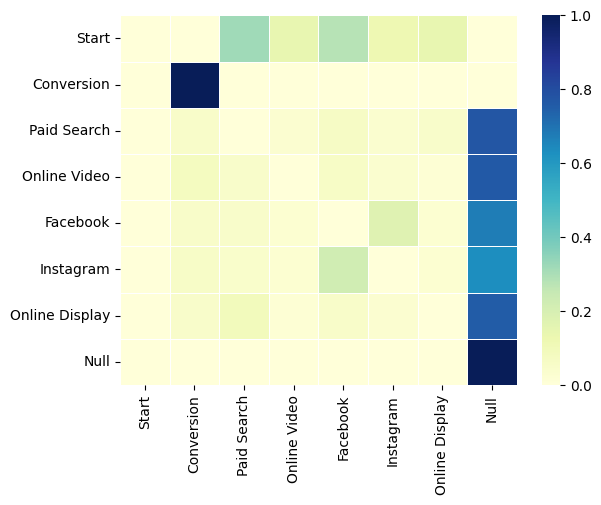

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

ax = sns.heatmap(trans_matrix, linewidth = 0.5, cmap = "YlGnBu")
plt.show()

## **5. Calculate Ad channel impact**

Calculate the effect of removing an ad channel

Assume the channel was not there. Remove the channel from both rows and columns of the transition probablilty matrix

Then recompute the probabilities of the transition matrix, so that the sum of the rows add up to 1

In [ ]:
def removal_efects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start', 'Null','Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct !=0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[['Null','Conversion']].drop(['Null','Conversion'],axis=0)
        removal_to_non_conv = removal_df.drop(['Null', 'Conversion'],axis=1).drop(['Null','Conversion'], axis=0)
        removal_inv_diff = np.linalg.inv(
            np.identity(len(removal_to_non_conv.columns)) -
            np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict

removal_effects_dict = removal_efects(trans_matrix, base_conversion_rate)
removal_effects_dict

{'Paid Search': 0.3311037560086154,
 'Online Video': 0.2069141165564219,
 'Facebook': 0.3547597674182722,
 'Instagram': 0.21731366149038456,
 'Online Display': 0.15435482356041286}

**Calculate the number of conversions impact by each channel**

1. Calculate the removal effect as a percentage of all channels
2. Calculate the proportion from the total conversion

In [ ]:
def markov_chain_allocation(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))
    return {k: ((v/re_sum) * total_conversions ) for k,v in removal_effects.items()}

attributions = markov_chain_allocation(removal_effects_dict, total_conversions)
attributions

{'Paid Search': 4618.891257291354,
 'Online Video': 2886.448089546146,
 'Facebook': 4948.892177847523,
 'Instagram': 3031.521548555892,
 'Online Display': 2153.246926759083}